<a id='notebook-top'></a>
This notebook shows the basic coalignment of observations made by Solar Orbiter and other near-Earth observatories. The details about 
how coalignments are made can be found in this [notebook](https://yjzhu-solar.github.io/EIS_DKIST_SolO/eis_eui_upflow_ipynb_html/aia_coalign_1024_final_rsuncorr.html).
Link to [Figure A.1](#figure-a-1).

Note: The internal hyperlink only works on [GitHub Pages](https://yjzhu-solar.github.io/EIS_DKIST_SolO/eis_eui_upflow_ipynb_html/coalign_flowmap.html) or [nbviewer](https://nbviewer.org/github/yjzhu-solar/EIS_DKIST_SolO/blob/master/ipynb/ms_eis_eui_upflow/coalign_flowmap.ipynb). Do not click when viewing the notebook on GitHub.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.transforms as transforms
from matplotlib import rc_context
import sunpy
import sunpy.map
from astropy.coordinates import SkyCoord
import astropy.units as u

from astropy.visualization import (AsinhStretch, LinearStretch,
        LogStretch, ImageNormalize,PowerStretch)

In [2]:
ms_style_dict = {'text.usetex': True, 'font.family': 'serif', 'axes.linewidth': 1.2,
                 'xtick.major.width': 1.2, 'xtick.major.size': 4,
                 'ytick.major.width': 1.2, 'ytick.major.size': 4,
                 'xtick.minor.width': 1.2, 'xtick.minor.size': 2,
                 'ytick.minor.width': 1.2, 'ytick.minor.size': 2,
                 'xtick.direction': 'in', 'ytick.direction': 'in',
                 'text.latex.preamble': r'\usepackage[T1]{fontenc}'
                 r'\usepackage{amsmath}' r'\usepackage{siunitx}'
                 r'\sisetup{detect-all=True}'}

In [3]:
def plot_map_pizza(ax, maps, cmaps=None, norms=None, xslice=None, yslice=None,
                    text=None, textcoords=(0.05,0.95),text_shadow=True):
    if not isinstance(maps, list):
        ax.imshow(maps, origin='lower')
    else:
        n_maps = len(maps)
        if n_maps == 3:
            maps = [maps[0], maps[1], maps[0], maps[2]]
            n_maps = 4

        maps_new = []
        if (xslice is not None) and (yslice is not None):
            for map_ in maps:
                maps_new.append(map_.submap([xslice[0],yslice[0]]*u.pix, 
                                top_right=[xslice[1],yslice[1]]*u.pix))
            maps = maps_new

        if n_maps == 1:
            if cmaps is not None:
                cmap = cmaps[0]
            else:
                cmap = maps[0].plot_settings['cmap']
            cmap = plt.get_cmap(cmap)

            if norms is not None:
                norm = norms[0]
            else:
                norm = maps[0].plot_settings['norm']
            ax.imshow(cmap(norm(maps[0].data)), origin='lower', aspect=maps[0].scale.axis2/maps[0].scale.axis1)
        else:
            map_shape = maps[0].data.shape
            pizza_array = np.zeros(map_shape + (4,))
            if n_maps == 2:
                sub_map_shape = (map_shape[0], map_shape[1]//2)
                for ii, map_ in enumerate(maps):
                    if cmaps is not None:
                        cmap = cmaps[ii]
                    else:
                        cmap = map_.plot_settings['cmap']
                    if isinstance(cmap, str):
                        cmap = plt.get_cmap(cmap)

                    if norms is not None:
                        norm = norms[ii]
                    else:
                        norm = map_.plot_settings['norm']

                    pizza_array[:,ii%2*sub_map_shape[1]:(ii%2 + 1)*sub_map_shape[1],:] = \
                        cmap(norm(map_.data[:,ii%2*sub_map_shape[1]:(ii%2 + 1)*sub_map_shape[1]]))
            
            elif n_maps == 4:
                sub_map_shape = (map_shape[0]//2, map_shape[1]//2)
                for ii, map_ in enumerate(maps):
                    if cmaps is not None:
                        cmap = cmaps[ii]
                    else:
                        cmap = map_.plot_settings['cmap']
                    cmap = plt.get_cmap(cmap)

                    if norms is not None:
                        norm = norms[ii]
                    else:
                        norm = map_.plot_settings['norm']

                    pizza_array[ii//2*sub_map_shape[0]:(ii//2 + 1)*sub_map_shape[0],ii%2*sub_map_shape[1]:(ii%2 + 1)*sub_map_shape[1],:] \
                        = cmap(norm(map_.data[ii//2*sub_map_shape[0]:(ii//2 + 1)*sub_map_shape[0],ii%2*sub_map_shape[1]:(ii%2 + 1)*sub_map_shape[1]]))

            ax.imshow(pizza_array, origin='lower', aspect=maps[0].scale.axis2/maps[0].scale.axis1)

    if text is not None:
        text_split = text.split('\n')
        text = '\n'.join([r"\textbf{{{}}}".format(text_line) for text_line in text_split])
        text_obj = ax.text(textcoords[0], textcoords[1], text, fontsize=12, color='white', ha='left', va='top',
        transform=ax.transAxes, path_effects=[path_effects.Stroke(linewidth=2, foreground='black'),
                          path_effects.Normal()] if text_shadow else None)

        # box=dict(facecolor='white', edgecolor='#91989F', alpha=0.3,
        #         boxstyle='round,pad=0.5')

    ax.axis('off')

In [4]:
def plot_array_pizza(ax, arrays, cmaps=None, norms=None, xslice=None, yslice=None,
                    text=None, textcoords=(0.05,0.95),text_shadow=True, aspect=1):
    if not isinstance(arrays, list):
        ax.imshow(arrays, origin='lower', cmap=cmaps[0] if isinstance(cmaps, list) else cmaps,
                  norm=norms[0] if isinstance(norms, list) else norms, aspect=aspect)
    else:
        n_arrays = len(arrays)
        if n_arrays == 3:
            arrays = [arrays[0], arrays[1], arrays[0], arrays[2]]
            n_arrays = 4
        
        arrays_new = []
        if (xslice is not None) and (yslice is not None):
            for array in arrays:
                arrays_new.append(array[yslice[0]:yslice[1]+1, xslice[0]:xslice[1]+1])
            arrays = arrays_new
        
        if n_arrays == 1:
            if cmaps is not None:
                cmap = plt.get_cmap(cmaps[0]) if isinstance(cmaps, list) else plt.get_cmap(cmaps)
            else:
                cmap = plt.get_cmap('gray')

            if norms is not None:
                norm = norms[0] if isinstance(norms, list) else norms
            else:
                norm = ImageNormalize()
            ax.imshow(cmap(norm(arrays[0])), origin='lower', aspect=aspect)
        else:
            array_shape = arrays[0].shape
            pizza_array = np.zeros(array_shape + (4,))
            if n_arrays == 2:
                sub_array_shape = (array_shape[0], array_shape[1]//2)
                for ii, array in enumerate(arrays):
                    if cmaps is not None:
                        cmap = plt.get_cmap(cmaps[ii])
                    else:
                        cmap = plt.get_cmap('gray')

                    if norms is not None:
                        norm = norms[ii]
                    else:
                        norm = ImageNormalize()

                    pizza_array[:,ii%2*sub_array_shape[1]:(ii%2 + 1)*sub_array_shape[1]] = \
                        cmap(norm(array[:,ii%2*sub_array_shape[1]:(ii%2 + 1)*sub_array_shape[1]]))
            
            elif n_arrays == 4:
                sub_array_shape = (array_shape[0]//2, array_shape[1]//2)
                for ii, array in enumerate(arrays):
                    if cmaps is not None:
                        cmap = plt.get_cmap(cmaps[ii])
                    else:
                        cmap = plt.get_cmap('gray')

                    if norms is not None:
                        norm = norms[ii]
                    else:
                        norm = ImageNormalize()

                    pizza_array[ii//2*sub_array_shape[0]:(ii//2 + 1)*sub_array_shape[0],ii%2*sub_array_shape[1]:(ii%2 + 1)*sub_array_shape[1]] \
                        = cmap(norm(array[ii//2*sub_array_shape[0]:(ii//2 + 1)*sub_array_shape[0],ii%2*sub_array_shape[1]:(ii%2 + 1)*sub_array_shape[1]]))
            
            ax.imshow(pizza_array, origin='lower', aspect=aspect)
        
    if text is not None:
        text_split = text.split('\n')
        text = '\n'.join([r"\textbf{{{}}}".format(text_line) for text_line in text_split])
        text_obj = ax.text(textcoords[0], textcoords[1], text, fontsize=12, color='white', ha='left', va='top',
        transform=ax.transAxes, path_effects=[path_effects.Stroke(linewidth=2, foreground='black'),
                          path_effects.Normal()] if text_shadow else None)
        
    ax.axis('off')

In [5]:
def arrow_connect(ax1, ax2, x_nodes, y_nodes, text_coords, text, color='black', 
                textrotation=0.,arrow_1=False, arrow_2=True,):
    
    n_nodes = len(x_nodes)

    if n_nodes == 2:
        if arrow_1 is False and arrow_2 is True:
            arrow_style = '-|>'
        elif arrow_1 is True and arrow_2 is False:
            arrow_style = '<|-'
        elif arrow_1 is False and arrow_2 is False:
            arrow_style = '-'
        else:
            arrow_style = '<|-|>'
        ax1.annotate('', xy=(x_nodes[1], y_nodes[1]), xytext=(x_nodes[0], y_nodes[0]),
        xycoords=ax2.transAxes, textcoords=ax1.transAxes, 
        arrowprops=dict(facecolor=color, edgecolor=color, arrowstyle=arrow_style, shrinkA=0, shrinkB=0)) 
    
    if n_nodes > 2:
        arrow_style_1 = '<|-' if arrow_1 is True else '-'
        arrow_style_2 = '-|>' if arrow_2 is True else '-'
        arrow_styles = [arrow_style_1] + ['-']*(n_nodes-2) + [arrow_style_2]

        for ii in range(n_nodes-2):
            ax1.annotate('', xy=(x_nodes[ii+1], y_nodes[ii+1]), xytext=(x_nodes[ii], y_nodes[ii]),
            xycoords=ax1.transAxes, textcoords=ax1.transAxes,
            arrowprops=dict(facecolor=color, edgecolor=color, arrowstyle=arrow_styles[ii], shrinkA=0, shrinkB=0))
        
        ax1.annotate('', xy=(x_nodes[-1], y_nodes[-1]), xytext=(x_nodes[-2], y_nodes[-2]),
            xycoords=ax2.transAxes, textcoords=ax1.transAxes,
            arrowprops=dict(facecolor=color, edgecolor=color, arrowstyle=arrow_styles[-1], shrinkA=0, shrinkB=0))
    
    if not '$' in text:
        text_split = text.split('\n')
        text = '\n'.join([r"\textbf{{{}}}".format(text_line) for text_line in text_split])

    ax1.text(text_coords[0], text_coords[1], text, fontsize=12, color='black', ha='center', va='center',
                bbox=dict(facecolor='white', edgecolor='none', alpha=1,
                boxstyle='round,pad=0.1'), transform=ax1.transAxes, rotation=textrotation)

In [6]:
aia_193_map_eis = sunpy.map.Map("../../src/AIA/20221025/193/lvl15/aia.lev1_euv_12s.2022-10-25T022003Z.193.image.fits")
aia_193_map = sunpy.map.Map("../../src/AIA/20221024/193/lvl15/aia.lev1_euv_12s.2022-10-24T192003Z.193.image.fits")
aia_193_map_eis_hh = sunpy.map.Map("../../src/AIA/20221024/193/lvl15/aia.lev1_euv_12s.2022-10-24T193851Z.193.image.fits")
aia_193_map_2322 = sunpy.map.Map("../../src/AIA/20221024/193/lvl15/aia.lev1_euv_12s.2022-10-24T232251Z.193.image.fits")

aia_193_map_eis_crop = aia_193_map_eis.submap(SkyCoord(-600*u.arcsec,-100*u.arcsec,frame=aia_193_map_eis.coordinate_frame),
                                        top_right=SkyCoord(-100*u.arcsec,600*u.arcsec,frame=aia_193_map_eis.coordinate_frame))

aia_193_map_eis_hh_crop = aia_193_map_eis_hh.submap(SkyCoord(-600*u.arcsec,-100*u.arcsec,frame=aia_193_map_eis_hh.coordinate_frame),
                                        top_right=SkyCoord(-100*u.arcsec,600*u.arcsec,frame=aia_193_map_eis_hh.coordinate_frame))

aia_193_map_crop = aia_193_map.submap(SkyCoord(-600*u.arcsec,-100*u.arcsec,frame=aia_193_map.coordinate_frame),
                                        top_right=SkyCoord(-100*u.arcsec,600*u.arcsec,frame=aia_193_map.coordinate_frame))

aia_193_map_2322_crop = aia_193_map_2322.submap(SkyCoord(-600*u.arcsec,-100*u.arcsec,frame=aia_193_map_2322.coordinate_frame),
                                        top_right=SkyCoord(-100*u.arcsec,600*u.arcsec,frame=aia_193_map_2322.coordinate_frame))


aia_171_map = sunpy.map.Map("../../src/AIA/20221024/171/lvl15/aia.lev1_euv_12s.2022-10-24T192003Z.171.image.fits")

aia_171_map_crop = aia_171_map.submap(SkyCoord(-600*u.arcsec,-100*u.arcsec,frame=aia_171_map.coordinate_frame),
                                        top_right=SkyCoord(-100*u.arcsec,600*u.arcsec,frame=aia_171_map.coordinate_frame))

aia_171_map_eis = sunpy.map.Map("../../src/AIA/20221025/171/lvl15/aia.lev1_euv_12s.2022-10-25T022003Z.171.image.fits")

aia_171_map_eis_crop = aia_171_map_eis.submap(SkyCoord(-600*u.arcsec,-100*u.arcsec,frame=aia_171_map_eis.coordinate_frame),
                                        top_right=SkyCoord(-100*u.arcsec,600*u.arcsec,frame=aia_171_map_eis.coordinate_frame))



aia_304_map = sunpy.map.Map("../../src/AIA/20221024/304/lvl15/aia.lev1_euv_12s.2022-10-24T192003Z.304.image.fits")

aia_304_map_crop = aia_304_map.submap(SkyCoord(-600*u.arcsec,-100*u.arcsec,frame=aia_304_map.coordinate_frame),
                                        top_right=SkyCoord(-100*u.arcsec,600*u.arcsec,frame=aia_304_map.coordinate_frame))

aia_1600_map = sunpy.map.Map("../../src/AIA/20221024/1600/lvl15/aia.lev1_uv_24s.2022-10-24T191951Z.1600.image.fits")

aia_1600_map_crop = aia_1600_map.submap(SkyCoord(-600*u.arcsec,-100*u.arcsec,frame=aia_1600_map.coordinate_frame), 
                                        top_right=SkyCoord(-100*u.arcsec,600*u.arcsec,frame=aia_1600_map.coordinate_frame))

aia_1700_map = sunpy.map.Map("../../src/AIA/20221024/1700/lvl15/aia.lev1_uv_24s.2022-10-24T191951Z.1700.image.fits")

aia_1700_map_crop = aia_1700_map.submap(SkyCoord(-600*u.arcsec,-100*u.arcsec,frame=aia_1700_map.coordinate_frame),
                                        top_right=SkyCoord(-100*u.arcsec,600*u.arcsec,frame=aia_1700_map.coordinate_frame))

aia_1700_map_2322 = sunpy.map.Map("../../src/AIA/20221024/1700/lvl15/aia.lev1_uv_24s.2022-10-24T232303Z.1700.image.fits")
aia_1700_map_2322_crop = aia_1700_map_2322.submap(SkyCoord(-600*u.arcsec,-100*u.arcsec,frame=aia_1700_map_2322.coordinate_frame),
                                        top_right=SkyCoord(-100*u.arcsec,600*u.arcsec,frame=aia_1700_map_2322.coordinate_frame))


In [7]:
hri_174_map_shifted_toaia = sunpy.map.Map("../../src/coalign_map/20221024/hri_174_map_shifted_toaia.fits")

In [8]:
fsi_174_map_hri_time_shift = sunpy.map.Map("../../src/coalign_map/20221024/fsi_174_map_hri_time_shift.fits")
fsi_304_map_hri_time_shift = sunpy.map.Map("../../src/coalign_map/20221024/fsi_304_map_hri_time_shift.fits")
fsi_304_map_hri_time_shift.plot_settings['cmap'] = "solar orbiterfsi304"
fsi_304_map_hri_time_shift.plot_settings['norm'] = ImageNormalize(stretch=AsinhStretch(0.05))

In [9]:
fsi_174_map_hri_time_shift_crop = fsi_174_map_hri_time_shift.submap(SkyCoord(500*u.arcsec,0*u.arcsec,frame=fsi_174_map_hri_time_shift.coordinate_frame),
                                    top_right=SkyCoord(2000*u.arcsec,1250*u.arcsec,frame=fsi_174_map_hri_time_shift.coordinate_frame))
fsi_304_map_hri_time_shift_crop = fsi_304_map_hri_time_shift.submap(SkyCoord(500*u.arcsec,0*u.arcsec,frame=fsi_304_map_hri_time_shift.coordinate_frame),
                                    top_right=SkyCoord(2000*u.arcsec,1250*u.arcsec,frame=fsi_304_map_hri_time_shift.coordinate_frame))

In [10]:
phi_los_map_shifted = sunpy.map.Map("../../src/coalign_map/20221024/phi_los_map_shifted.fits")
phi_los_map_shifted.plot_settings['cmap'] = "hmimag"
phi_los_map_shifted.plot_settings['norm'] = ImageNormalize(vmin=-1000,vmax=1000)

In [11]:
hmi_los_map = sunpy.map.Map("../../src/HMI/20221024/lvl15/hmi.M_45s.20221024_192100_TAI.2.magnetogram.fits")
hmi_los_map_to_aia = hmi_los_map.reproject_to(aia_193_map.wcs)
hmi_los_map_crop = hmi_los_map_to_aia.submap(SkyCoord(-600*u.arcsec,-100*u.arcsec,frame=hmi_los_map_to_aia.coordinate_frame),
                                        top_right=SkyCoord(-100*u.arcsec,600*u.arcsec,frame=hmi_los_map_to_aia.coordinate_frame))

In [12]:
spice_NeVIII_intmap_derot_shift = sunpy.map.Map("../../src/coalign_map/20221024/spice_NeVIII_intmap_derot_repro_hrifov.fits")
spice_NeVIII_intmap_derot_shift.plot_settings['cmap'] = "sohoeit171"
spice_NeVIII_intmap_derot_shift.plot_settings['norm'] = ImageNormalize(vmin=0,vmax=10,stretch=AsinhStretch(0.01))

spice_NeVIII_velmap_derot_shift = sunpy.map.Map("../../src/coalign_map/20221024/spice_NeVIII_velmap_derot_repro_hrifov.fits")
spice_NeVIII_velmap_derot_shift.plot_settings['cmap'] = "coolwarm"
spice_NeVIII_velmap_derot_shift.plot_settings['norm'] = ImageNormalize(vmin=-40,vmax=40,)

In [13]:
fsi_174_map = sunpy.map.Map("../../src/EUI/FSI/euv174/20221024/solo_L2_eui-fsi174-image_20221024T192050179_V01.fits")
fsi_304_map = sunpy.map.Map("../../src/EUI/FSI/euv304/20221024/solo_L2_eui-fsi304-image_20221024T192020179_V01.fits")

In [14]:
eis_195_intmap_shift = sunpy.map.Map("../../src/EIS/DHB_007_v2/20221025T0023/sunpymaps/eis_195_intmap_shift.fits")
eis_195_velmap_shift = sunpy.map.Map("../../src/EIS/DHB_007_v2/20221025T0023/sunpymaps/eis_195_velmap_shift.fits")
eis_195_intmap_shift.plot_settings['cmap'] = plt.get_cmap("hinodexrt").reversed()
eis_195_intmap_shift.plot_settings['norm'] = ImageNormalize(stretch=AsinhStretch(0.4))
eis_195_velmap_shift.plot_settings['cmap'] = "coolwarm"
eis_195_velmap_shift.plot_settings['norm'] = ImageNormalize(vmin=-15,vmax=15,)

In [15]:
eis_hhflare_195_intmap_shift = sunpy.map.Map("../../src/coalign_map/20221024/eis_hhflare_195_intmap_shift.fits")
eis_hhflare_195_intmap_shift.plot_settings['cmap'] = plt.get_cmap("hinodexrt").reversed()
eis_hhflare_195_intmap_shift.plot_settings['norm'] = ImageNormalize(stretch=AsinhStretch(0.4))
eis_hhflare_195_velmap_shift = sunpy.map.Map("../../src/coalign_map/20221024/eis_hhflare_195_velmap_shift.fits")
eis_hhflare_195_velmap_shift.plot_settings['cmap'] = "coolwarm"
eis_hhflare_195_velmap_shift.plot_settings['norm'] = ImageNormalize(vmin=-15,vmax=15,)

In [16]:
chase_halpha_core_map_align_shift = sunpy.map.Map("../../src/coalign_map/20221024/chase_halpha_core_map_align_shift.fits")
chase_halpha_core_map_align_shift.plot_settings['cmap'] = "afmhot"
chase_halpha_line_width_map_align_shift = sunpy.map.Map("../../src/coalign_map/20221024/chase_halpha_line_width_map_align_shift.fits")
chase_halpha_line_width_map_align_shift.plot_settings['cmap'] = "plasma"
chase_halpha_line_width_map_align_shift.plot_settings['norm'] = ImageNormalize(vmin=0.9,vmax=1.35)

In [17]:
iris_1400_sji_2322_map_rotate_crop_shift = sunpy.map.Map("../../src/coalign_map/20221024/iris_1400_sji_2322_0_map_rotate_crop_shift.fits")
iris_1400_sji_2322_map_rotate_crop_shift.plot_settings['cmap'] = "irissji1400"
iris_1400_sji_2322_map_rotate_crop_shift.plot_settings['norm'] = ImageNormalize(vmin=np.nanpercentile(iris_1400_sji_2322_map_rotate_crop_shift.data,1),
                                                                                vmax=np.nanpercentile(iris_1400_sji_2322_map_rotate_crop_shift.data,99),stretch=AsinhStretch(0.1))

In [18]:
iris_SiIV_1394_intmap_rotate_shift_2322 = sunpy.map.Map("../../src/IRIS/20221024/2322/fit_res/iris_SiIV_1394_intmap_rotate_shift.fits")
iris_SiIV_1394_intmap_rotate_shift_2322_repro_tosji = iris_SiIV_1394_intmap_rotate_shift_2322.reproject_to(iris_1400_sji_2322_map_rotate_crop_shift.wcs)
iris_SiIV_1394_intmap_rotate_shift_2322_repro_tosji.plot_settings['cmap'] = "irissjiFUV"
iris_SiIV_1394_intmap_rotate_shift_2322_repro_tosji.plot_settings['norm'] = ImageNormalize(vmin=np.nanpercentile(iris_SiIV_1394_intmap_rotate_shift_2322_repro_tosji.data,3),
                                                                                           vmax=np.nanpercentile(iris_SiIV_1394_intmap_rotate_shift_2322_repro_tosji.data,97),
                                                                                           stretch=AsinhStretch(0.05))
iris_SiIV_1394_velmap_rotate_shift_2322 = sunpy.map.Map("../../src/IRIS/20221024/2322/fit_res/SiIV_1393_vel_map_no_mask.fits")
iris_SiIV_1394_velmap_rotate_shift_2322 = iris_SiIV_1394_velmap_rotate_shift_2322.rotate()
iris_SiIV_1394_velmap_rotate_shift_2322_repro_tosji = iris_SiIV_1394_velmap_rotate_shift_2322.reproject_to(iris_1400_sji_2322_map_rotate_crop_shift.wcs)
iris_SiIV_1394_velmap_rotate_shift_2322_repro_tosji.plot_settings['cmap'] = "coolwarm"
iris_SiIV_1394_velmap_rotate_shift_2322_repro_tosji.plot_settings['norm'] = ImageNormalize(vmin=-15,vmax=15)

For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]


In [19]:
iris_1400_sji_1920_map_rotate_shift = sunpy.map.Map("../../src/coalign_map/20221024/iris_1400_sji_1920_map_rotate_shift.fits")
iris_1400_sji_1920_map_rotate_shift.plot_settings['cmap'] = "irissji1400"
iris_1400_sji_1920_map_rotate_shift.plot_settings['norm'] = ImageNormalize(vmin=0,
                                                                           vmax=np.nanpercentile(iris_1400_sji_1920_map_rotate_shift.data,99.9),stretch=AsinhStretch(0.1))

In [20]:
aia_193_map_0220_synthetic_raster = np.load("../../src/EIS/eis_pointing/eis_20221025_014811//pointing_verification/20221025_014811/intensity_data_step_3_optimal.npz")

In [21]:
fsi_174_2315_spice_synthetic_raster = np.load('../../src/EUI/FSI/euv174/20221024/for_spice/eui_syn_raster_image_for_spice.npz')

<a id='figure-a-1'></a>
### Figure A.1
(You may have to pull down to see the notebook preview of the figure)

[back to top](#notebook-top) 

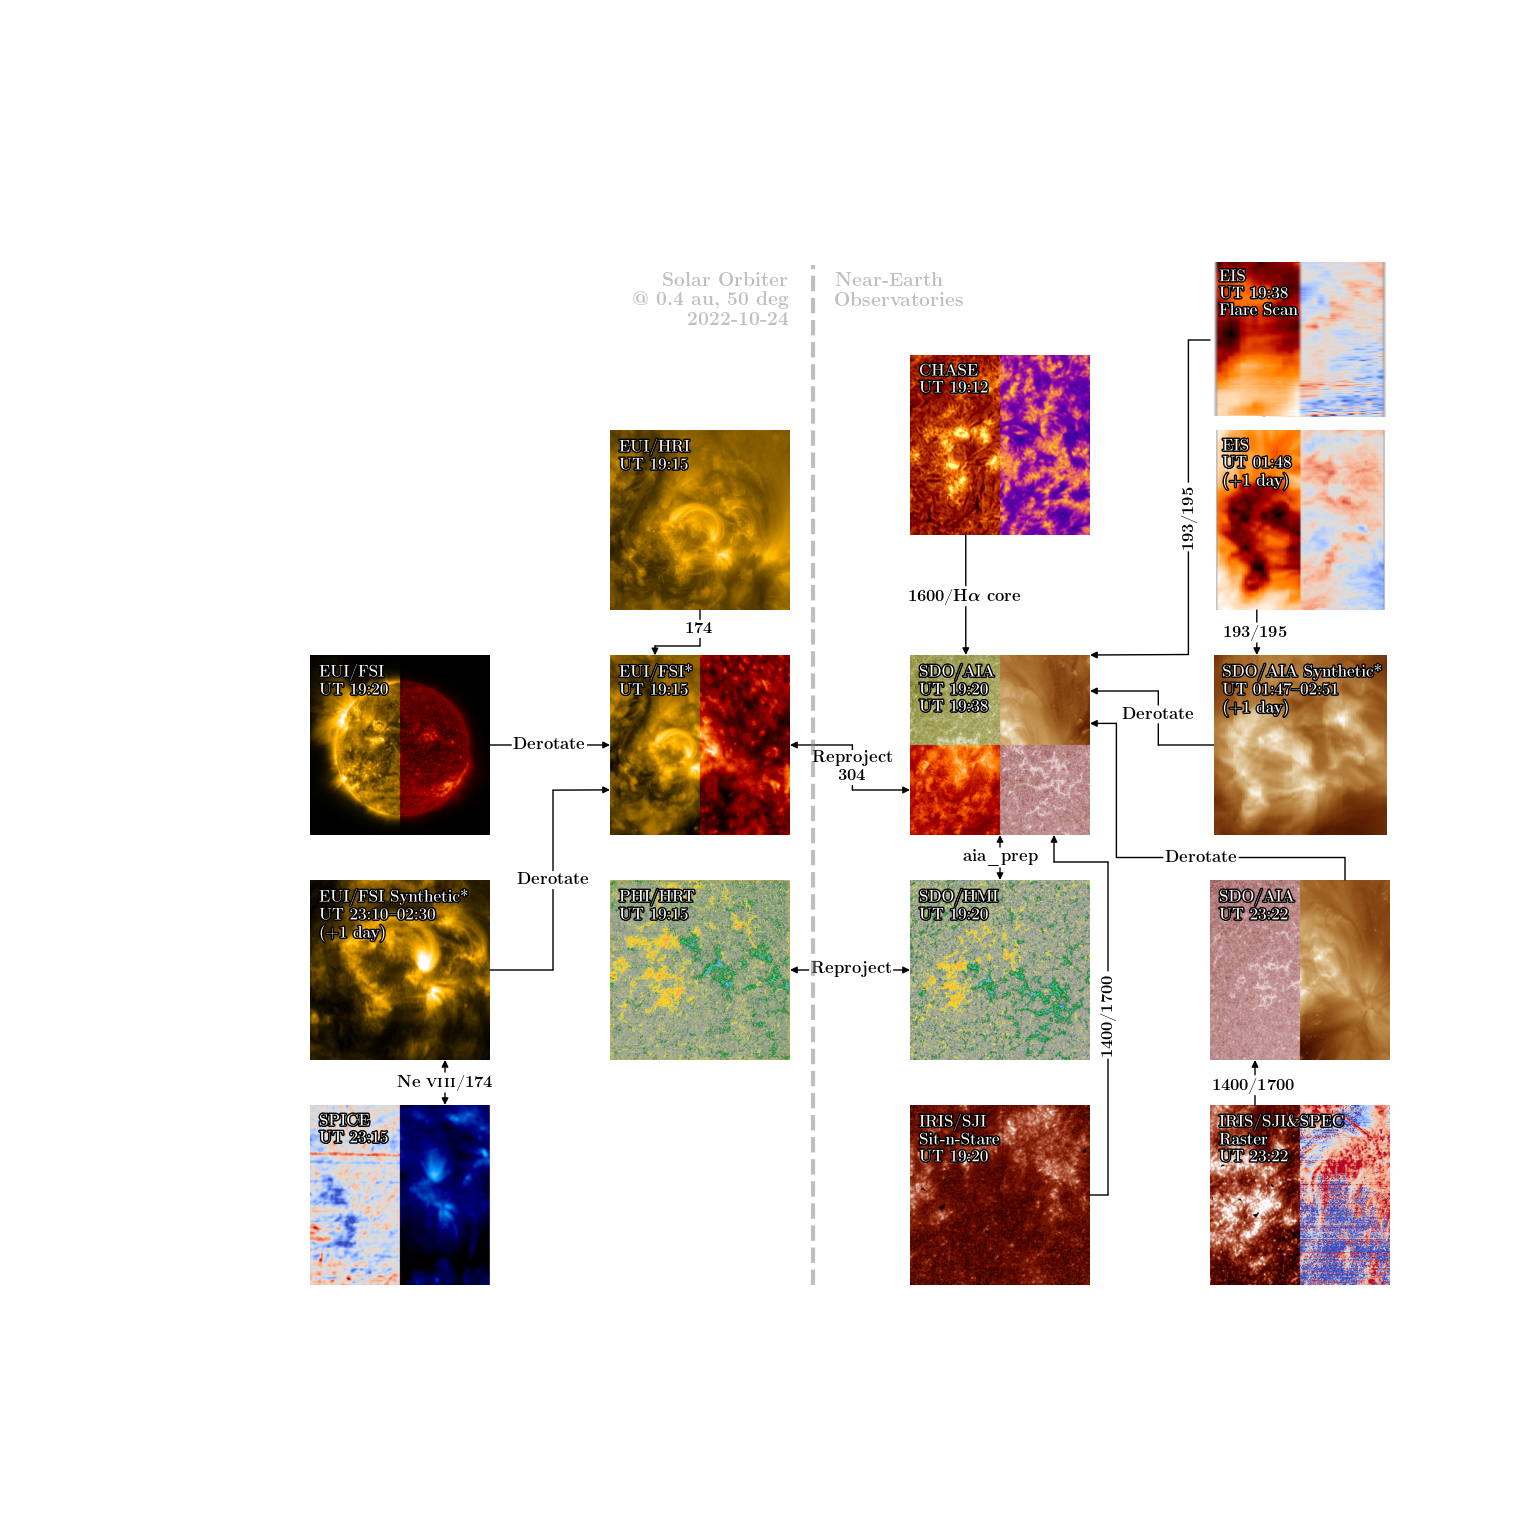

In [22]:
with rc_context(ms_style_dict):
    plt.close()
    fig = plt.figure(figsize=(15,15))

    ax_aia_1920 = fig.add_axes([0.6,0.45,0.12,0.12])
    ax_fsi_1915 = fig.add_axes([0.4,0.45,0.12,0.12])
    ax_hri_1915 = fig.add_axes([0.4,0.60,0.12,0.12])
    ax_phi_1915 = fig.add_axes([0.4,0.3,0.12,0.12])
    ax_hmi_1920 = fig.add_axes([0.6,0.3,0.12,0.12])
    ax_fsi_syn_2315 = fig.add_axes([0.2,0.3,0.12,0.12])
    ax_spice_2315 = fig.add_axes([0.2,0.15,0.12,0.12])
    ax_fsi_1920 = fig.add_axes([0.2,0.45,0.12,0.12])
    ax_aia_0220 = fig.add_axes([0.8,0.45,0.12,0.12])
    ax_aia_2322 = fig.add_axes([0.8,0.3,0.12,0.12])
    ax_eis_0220 = fig.add_axes([0.8,0.6,0.12,0.12])
    ax_eis_1938 = fig.add_axes([0.8,0.72,0.12,0.12])
    ax_chase_1912 = fig.add_axes([0.6,0.65,0.12,0.12])
    # ax_visp_1915 = fig.add_axes([0.545,0.6,0.08,0.12])
    ax_iris_2322 = fig.add_axes([0.8,0.15,0.12,0.12])
    ax_iris_1920 = fig.add_axes([0.6,0.15,0.12,0.12])

    ax_fig = fig.add_axes([0,0,1,1])
    ax_fig.axis('off')

    # ax_vbi_1900 = fig.add_axes([0.65,0.6,0.12,0.12])
    # ax_vbi_1900.tick_params(which="major",axis="x",bottom=False,labelbottom=False)
    # ax_vbi_1900.tick_params(which="major",axis="y",left=False,labelleft=False)
    # ax_vbi_1900.imshow(vbi_combined)
    # text_vbi_1900 = ax_vbi_1900.text(0.05,0.95,"DKIST/VBI\nUT 19:00\nJPEG Preview",fontsize=12,color='white',ha='left',va='top',
    #         transform=ax_vbi_1900.transAxes)
    # text_vbi_1900.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
    #                         path_effects.Normal()])
    # ax_vbi_1900.axis('off')


    plot_map_pizza(ax_aia_1920, [aia_304_map_crop,aia_1700_map_crop,aia_1600_map_crop,aia_193_map_crop,],
                    xslice=[0,799], yslice=[200,999],text='SDO/AIA\nUT 19:20\nUT 19:38')

    plot_map_pizza(ax_fsi_1915, [fsi_174_map_hri_time_shift_crop, fsi_304_map_hri_time_shift_crop],
                    xslice=[0,299], yslice=[10,349],text='EUI/FSI*\nUT 19:15')

    arrow_connect(ax_aia_1920, ax_fsi_1915, [0,-0.32,-0.32,1], [0.25,0.25,0.5,0.5], [-0.32,0.375], 'Reproject\n304', color='black',
                    textrotation=0.,arrow_1=True, arrow_2=True)

    plot_map_pizza(ax_hri_1915, [hri_174_map_shifted_toaia],
                    text='EUI/HRI\nUT 19:15')

    arrow_connect(ax_hri_1915, ax_fsi_1915, [0.5,0.5,0.25,0.25], [0,-0.2,-0.2,1], [0.5,-0.105], '174', color='black',
                    textrotation=0.,arrow_1=False, arrow_2=True)

    plot_map_pizza(ax_phi_1915, [phi_los_map_shifted],
                    text='PHI/HRT\nUT 19:15')

    plot_map_pizza(ax_hmi_1920, [hmi_los_map_crop], 
                    text='SDO/HMI\nUT 19:20', norms=[ImageNormalize(vmin=-1000,vmax=1000)],
                    cmaps=['hmimag'], xslice=[0,799], yslice=[200,999])

    arrow_connect(ax_hmi_1920, ax_aia_1920, [0.5,0.5], [1,0], [0.5,1.125], 'aia_prep', color='black',
                    textrotation=0.,arrow_1=True, arrow_2=True)

    arrow_connect(ax_phi_1915, ax_hmi_1920, [1,0.], [0.5,0.5], [1.34,0.5], 'Reproject', color='black',
                    textrotation=0.,arrow_1=True, arrow_2=True)

    plot_array_pizza(ax_fsi_syn_2315, [fsi_174_2315_spice_synthetic_raster['eui_syn_raster_image']],
                            text='EUI/FSI Synthetic*\nUT 23:10--02:30\n(+1 day)', aspect=1.098/4,
                            cmaps='sdoaia171', norms=ImageNormalize(vmin=np.nanpercentile(fsi_174_2315_spice_synthetic_raster['eui_syn_raster_image'],0.2),
                                                                    vmax=np.nanpercentile(fsi_174_2315_spice_synthetic_raster['eui_syn_raster_image'],99.8),
                                                                    stretch=AsinhStretch(0.1)),
                            xslice=[10,170], yslice=[205,790])

    plot_map_pizza(ax_spice_2315, [spice_NeVIII_velmap_derot_shift,spice_NeVIII_intmap_derot_shift],
                    text='SPICE\nUT 23:15', xslice=[500,1500], yslice=[200,1200])

    plot_map_pizza(ax_fsi_1920, [fsi_174_map, fsi_304_map],
                    text='EUI/FSI\nUT 19:20', xslice=[500,1999], yslice=[700,2199])

    arrow_connect(ax_fsi_1920, ax_fsi_1915, [1,0], [0.5,0.5], [1.33,0.5], 'Derotate', color='black',
                    textrotation=0.,arrow_1=False, arrow_2=True)
    
    arrow_connect(ax_spice_2315, ax_fsi_syn_2315, [0.75,0.75], [1,0], [0.75,1.125], r'Ne \textsc{{viii}}/174', color='black',
                    textrotation=0.,arrow_1=True, arrow_2=True)
    
    arrow_connect(ax_fsi_syn_2315, ax_fsi_1915, [1,1.35,1.35,0], [0.5,0.5,1.5,0.5-0.25], [1.35,1], 'Derotate', color='black',
                    textrotation=0.,arrow_1=False, arrow_2=True)

    # arrow_connect(ax_spice_2315, ax_fsi_1915, [1,1.35,1.35,0], [0.5,0.5,1.5,0.5-0.25], [1.35,1], 'Derotate\nNe VIII/174', color='black',
    #                 textrotation=0.,arrow_1=False, arrow_2=True)

    # plot_map_pizza(ax_aia_0220, [aia_193_map_eis_crop, aia_171_map_eis_crop],
    #                 text='SDO/AIA synthetic\nUT 01:48-02:51\n(+1 day)', xslice=[0,799], yslice=[200,999])

    plot_array_pizza(ax_aia_0220, [aia_193_map_0220_synthetic_raster['aia_int']],
                            text='SDO/AIA Synthetic*\nUT 01:47--02:51\n(+1 day)', xslice=[0,62], yslice=[200,453],
                            aspect=eis_195_intmap_shift.scale.axis2/eis_195_intmap_shift.scale.axis1,
                            cmaps='sdoaia193',norms=ImageNormalize(vmin=np.nanmin(aia_193_map_0220_synthetic_raster['aia_int']),
                                                            vmax=np.nanmax(aia_193_map_0220_synthetic_raster['aia_int']),
                                                            stretch=AsinhStretch(0.1)))

    arrow_connect(ax_aia_0220, ax_aia_1920, [0,-0.32,-0.32,1], [0.5,0.5,0.8,0.8], [-0.32,0.67], 'Derotate', color='black',
                    textrotation=0.,arrow_1=False, arrow_2=True)

    plot_map_pizza(ax_aia_2322, [aia_1700_map_2322_crop,aia_193_map_2322_crop,],
                    text='SDO/AIA\nUT 23:22', xslice=[0,799], yslice=[200,999])

    arrow_connect(ax_aia_2322, ax_aia_1920, [0.75,0.75,-0.52,-0.52,1], [1,1.125,1.125,1.62+0.25,0.62], [-0.05,1.125], 'Derotate', color='black',
                    textrotation=0.,arrow_1=False, arrow_2=True)

    plot_map_pizza(ax_eis_0220, [eis_195_intmap_shift,eis_195_velmap_shift],
                    text='EIS\nUT 01:48\n(+1 day)', xslice=[0,62], yslice=[200,453])

    arrow_connect(ax_eis_0220, ax_aia_0220, [0.25,0.25], [0,1], [0.25,-0.25/2.], '193/195', color='black',
                    textrotation=0.,arrow_1=False, arrow_2=True)

    plot_map_pizza(ax_eis_1938, [eis_hhflare_195_intmap_shift,eis_hhflare_195_velmap_shift],
                    text='EIS\nUT 19:38\nFlare Scan')

    arrow_connect(ax_eis_1938, ax_aia_1920, [0,-0.12,-0.12,1], [0.5,0.5,-1.512,1], [-0.12,-1.265/2], '193/195', color='black',
                    textrotation=90.,arrow_1=False, arrow_2=True)

    plot_map_pizza(ax_chase_1912, [chase_halpha_core_map_align_shift,chase_halpha_line_width_map_align_shift],
                    text='CHASE\nUT 19:12',xslice=[0,287],yslice=[0,287])

    arrow_connect(ax_chase_1912, ax_aia_1920, [0.31,0.31], [0,1], [0.31,-0.34], r'\textbf{1600/H}$\boldsymbol{\alpha}$ \textbf{core}', color='black',
                    textrotation=0.,arrow_1=False, arrow_2=True)

    # plot_map_pizza(ax_visp_1915, [dkist_fitv_tom_cont_int_map_shift,dkist_fitv_tom_btot_map_shift,
    #                                 dkist_fitv_tom_DoppVel_map_shifted,dkist_ftiv_tom_theta_map_shifted_masked],
    #                 text='DKIST/ViSP\nUT 19:15',xslice=[0,687],yslice=[500,2554])

    # arrow_connect(ax_visp_1915, ax_aia_1920, [0.8,0.8,1.04,0.2], [0,-0.125,-0.125,1], [0.85,-0.115], r'$B_{\rm tot}$/1600', color='black',
    #                 textrotation=0.,arrow_1=False, arrow_2=True)

    plot_map_pizza(ax_iris_2322, [iris_1400_sji_2322_map_rotate_crop_shift,
                                    iris_SiIV_1394_velmap_rotate_shift_2322_repro_tosji],
                    text=r'IRIS/SJI\&SPEC' + '\n' + 'Raster' + '\n' + 'UT 23:22',xslice=[50,405],yslice=[50,405],)

    arrow_connect(ax_iris_2322, ax_aia_2322, [0.25,0.25], [1,0], [0.25,1.11], r'1400/1700', color='black',
                    textrotation=0.,arrow_1=False, arrow_2=True)

    plot_map_pizza(ax_iris_1920, [iris_1400_sji_1920_map_rotate_shift],
                    text='IRIS/SJI\nSit-n-Stare\nUT 19:20',xslice=[30,329],yslice=[30,329])      

    arrow_connect(ax_iris_1920, ax_aia_1920, [1,1.1,1.1,0.8,0.8], [0.5,0.5,2.35,2.35,0], [1.1,1.5], r'1400/1700', color='black',
                    textrotation=90.,arrow_1=False, arrow_2=True)  

    ax_fig.axvline(0.535,0.15,0.83,linestyle='--',color='grey',alpha=0.5,linewidth=3,zorder=0)
    ax_fig.text(0.55,0.825,r"\textbf{Near-Earth}" + "\n" + r"\textbf{Observatories}",fontsize=14,color='grey',ha='left',va='top',
                    alpha=0.5,transform=ax_fig.transAxes)

    ax_fig.text(0.52,0.825,r"\textbf{Solar Orbiter}"+"\n"+r"\textbf{@ 0.4 au, 50 deg}"+"\n"+r"\textbf{2022-10-24}",fontsize=14,color='grey',ha='right',va='top',
                    alpha=0.5,transform=ax_fig.transAxes)
    
    plt.savefig("../../figs/ms_eis_eui_upflow/coalign_example.pdf",dpi=300,bbox_inches=transforms.Bbox([[2.9,2.2],[13.85,12.5]]),pad_inches=0.)

    plt.show()